In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd  # Veri işleme
import numpy as np  # Sayısal işlemler
import matplotlib.pyplot as plt  # Veri görselleştirme
import seaborn as sns  # İstatistiksel veri görselleştirme
import gc

In [5]:
games = pd.read_csv('games.csv')
recommendations = pd.read_csv('recommendations.csv')
users = pd.read_csv('users.csv')

In [6]:
print("games.csv başlıkları:", list(games.columns))

games.csv başlıkları: ['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews', 'price_final', 'price_original', 'discount', 'steam_deck']


In [7]:
print("recommendations.csv başlıkları:", list(recommendations.columns))

recommendations.csv başlıkları: ['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'hours', 'user_id', 'review_id']


In [8]:
print("users.csv başlıkları:", list(users.columns))

users.csv başlıkları: ['user_id', 'products', 'reviews']


In [9]:
print("games.csv veri tipleri:\n", games.dtypes)

games.csv veri tipleri:
 app_id              int64
title              object
date_release       object
win                  bool
mac                  bool
linux                bool
rating             object
positive_ratio      int64
user_reviews        int64
price_final       float64
price_original    float64
discount          float64
steam_deck           bool
dtype: object


In [10]:
print("\nrecommendations.csv veri tipleri:\n", recommendations.dtypes)


recommendations.csv veri tipleri:
 app_id              int64
helpful             int64
funny               int64
date               object
is_recommended       bool
hours             float64
user_id             int64
review_id           int64
dtype: object


In [11]:
print("\nusers.csv veri tipleri:\n", users.dtypes)


users.csv veri tipleri:
 user_id     int64
products    int64
reviews     int64
dtype: object


In [13]:
# recommendations.csv'deki date sütununu datetime formatına çevir
recommendations['date'] = pd.to_datetime(recommendations['date'], errors='coerce')

In [14]:
# date sütunundaki hatalı dönüşümleri kontrol et (NaT olanlar)
print("Date sütununda hatalı dönüşüm (NaT) sayısı:", recommendations['date'].isnull().sum())

Date sütununda hatalı dönüşüm (NaT) sayısı: 0


In [15]:
# 1 inceleme yazan kullanıcıları belirleme
single_review_users = users[users['reviews'] == 1]['user_id']

# Bu kullanıcıları recommendations veri setinden çıkarma
filtered_recommendations = recommendations[~recommendations['user_id'].isin(single_review_users)]

# Sonuçları kontrol etme
print(f"Orijinal recommendations veri setindeki satır sayısı: {len(recommendations)}")
print(f"Filtrelenmiş recommendations veri setindeki satır sayısı: {len(filtered_recommendations)}")
print(f"Çıkarılan kullanıcı sayısı: {len(single_review_users)}")

Orijinal recommendations veri setindeki satır sayısı: 41154794
Filtrelenmiş recommendations veri setindeki satır sayısı: 33581767
Çıkarılan kullanıcı sayısı: 7573027


In [16]:
# 1. games veri setinden kriterlere uygun oyunları tespit et
excluded_games = games[
    (games['price_original'] > 20) |       # 20 dolardan pahalı oyunlar
    (games['positive_ratio'] < 75) |      # positive_ratio 75'ten düşük olan oyunlar
    (pd.to_datetime(games['date_release']).dt.year < 2000)  # 2000 yılından önce çıkan oyunlar
]

# Tespit edilen oyunların app_id'lerini al
excluded_app_ids = excluded_games['app_id']

# 2. Bu app_id'leri filtered_recommendations veri setinden çıkar
filtered_recommendations = filtered_recommendations[
    ~filtered_recommendations['app_id'].isin(excluded_app_ids)
]

# Sonuçları kontrol et
print(f"Orijinal filtered_recommendations satır sayısı: {len(recommendations)}")
print(f"Yeni filtered_recommendations satır sayısı: {len(filtered_recommendations)}")
print(f"Çıkarılan oyun sayısı: {len(excluded_app_ids)}")

Orijinal filtered_recommendations satır sayısı: 41154794
Yeni filtered_recommendations satır sayısı: 26491077
Çıkarılan oyun sayısı: 20614


In [17]:
# games veri setinde user_reviews sütununu kullanarak inceleme sayısı 50'den düşük olan oyunları bul
low_review_games = games[games['user_reviews'] < 100]

# Bu oyunların app_id'lerini al
low_review_app_ids = low_review_games['app_id']

# filtered_recommendations veri setinden bu app_id'leri çıkar
filtered_recommendations = filtered_recommendations[
    ~filtered_recommendations['app_id'].isin(low_review_app_ids)
]

print(f"50'den az inceleme yapılan oyunlar çıkarıldı.")
print(f"Kalan satır sayısı: {len(filtered_recommendations)}")

50'den az inceleme yapılan oyunlar çıkarıldı.
Kalan satır sayısı: 26212857


In [18]:
# users veri setinden 2 inceleme yapmış kullanıcıları bul
two_review_users = users[users['reviews'] == 2]

# Bu kullanıcıların user_id'lerini al
two_review_user_ids = two_review_users['user_id']

# filtered_recommendations veri setinden bu user_id'leri çıkar
filtered_recommendations = filtered_recommendations[
    ~filtered_recommendations['user_id'].isin(two_review_user_ids)
]

print(f"2 inceleme yapmış kullanıcılar çıkarıldı.")
print(f"Kalan satır sayısı: {len(filtered_recommendations)}")

2 inceleme yapmış kullanıcılar çıkarıldı.
Kalan satır sayısı: 22296064


In [19]:
# games veri setinde price_original sütununu kullanarak 3 dolardan ucuz oyunları bul
cheap_games = games[games['price_original'] < 3]

# Bu oyunların app_id'lerini al
cheap_game_app_ids = cheap_games['app_id']

# filtered_recommendations veri setinden bu app_id'leri çıkar
filtered_recommendations = filtered_recommendations[
    ~filtered_recommendations['app_id'].isin(cheap_game_app_ids)
]

# Sonuçları kontrol et
print(f"3 dolardan ucuz oyunlar çıkarıldı.")
print(f"Kalan satır sayısı: {len(filtered_recommendations)}")

3 dolardan ucuz oyunlar çıkarıldı.
Kalan satır sayısı: 7356932


In [20]:
# 1. Recommendations'da kalan kullanıcı ve oyun ID'lerini al
valid_user_ids = filtered_recommendations['user_id'].unique()
valid_game_ids = filtered_recommendations['app_id'].unique()

# 2. Games veri setini temizle (sadece valid_game_ids'deki oyunlar kalsın)
cleaned_games = games[games['app_id'].isin(valid_game_ids)]
print(f"Temizlenmiş Games Veri Seti Boyutu: {cleaned_games.shape}")

# 3. Users veri setini temizle (sadece valid_user_ids'deki kullanıcılar kalsın)
cleaned_users = users[users['user_id'].isin(valid_user_ids)]
print(f"Temizlenmiş Users Veri Seti Boyutu: {cleaned_users.shape}")

Temizlenmiş Games Veri Seti Boyutu: (6228, 13)
Temizlenmiş Users Veri Seti Boyutu: (2368365, 3)


In [21]:
# 1. Recommendations ve Users'ı user_id üzerinden birleştir
merged_users_recommendations = pd.merge(
    filtered_recommendations,
    cleaned_users,
    on='user_id',
    how='inner'
)

# 2. Yukarıdaki veri setini Games ile app_id üzerinden birleştir
merged_dataset = pd.merge(
    merged_users_recommendations,
    cleaned_games,
    on='app_id',
    how='inner'
)

# 3. Birleştirilmiş veri setinin boyutunu ve örnek bir kısmını görüntüle
print(f"Birleştirilmiş Veri Seti Boyutu: {merged_dataset.shape}")
print(merged_dataset.head())

Birleştirilmiş Veri Seti Boyutu: (7356932, 22)
    app_id  helpful  funny       date  is_recommended  hours   user_id  \
0  1766740        0      0 2022-12-18            True   12.7   6766810   
1  1766740        7      0 2022-12-26           False    2.8   7984323   
2  1766740        0      0 2022-12-13           False    3.7  13376299   
3  1766740        0      0 2022-12-10            True    2.9   5668417   
4  1766740        0      0 2022-12-09            True    3.1   5737183   

   review_id  products  reviews  ...   win    mac  linux         rating  \
0       2090       199       25  ...  True  False  False  Very Positive   
1       4283       181        7  ...  True  False  False  Very Positive   
2       6864        23        4  ...  True  False  False  Very Positive   
3       8615        58        5  ...  True  False  False  Very Positive   
4       8803       642        9  ...  True  False  False  Very Positive   

   positive_ratio user_reviews  price_final  price_origin

In [22]:
# Gereksiz sütunları kaldır
columns_to_drop = ['funny', 'helpful', 'win', 'mac', 'linux', 'price_final', 'discount', 'steam_deck']
merged_dataset = merged_dataset.drop(columns=columns_to_drop, axis=1)

# Güncel veri setinin boyutunu ve sütunlarını kontrol edin
print(f"Güncel Veri Seti Boyutu: {merged_dataset.shape}")
print(f"Kalan Sütunlar: {list(merged_dataset.columns)}")

Güncel Veri Seti Boyutu: (7356932, 14)
Kalan Sütunlar: ['app_id', 'date', 'is_recommended', 'hours', 'user_id', 'review_id', 'products', 'reviews', 'title', 'date_release', 'rating', 'positive_ratio', 'user_reviews', 'price_original']


In [23]:
# Eksik veri kontrolü
missing_data = merged_dataset.isnull().sum()

# Eksik veri içeren sütunları yazdır
print("Eksik Veriler:")
print(missing_data[missing_data > 0])

Eksik Veriler:
Series([], dtype: int64)


In [24]:
# merged_dataset'i kopyala
merged_dataset_copy = merged_dataset.copy()

In [25]:
merged_dataset_copy['user_id'] = merged_dataset_copy['user_id'].astype('int32')
merged_dataset_copy['app_id'] = merged_dataset_copy['app_id'].astype('int32')
merged_dataset_copy['hours'] = merged_dataset_copy['hours'].astype('float32')

In [26]:
from scipy.sparse import coo_matrix

# Kullanıcı ve oyun ID'lerini kategorik kodlara dönüştür
rows = merged_dataset['user_id'].astype('category').cat.codes
cols = merged_dataset['app_id'].astype('category').cat.codes

# is_recommended sütununu sparse matrise değer olarak kullan
data = merged_dataset['is_recommended'].astype(int)  # True/False'u 1/0'a çeviriyoruz

# COO formatında sparse matris oluştur
sparse_matrix = coo_matrix((data, (rows, cols)))

# Matrisin boyutlarını kontrol et
print(f"Sparse matrix boyutları: {sparse_matrix.shape}")
print(f"Sparse matrix dolu eleman sayısı: {sparse_matrix.nnz}")

Sparse matrix boyutları: (2368365, 6228)
Sparse matrix dolu eleman sayısı: 7356932


In [27]:
from sklearn.model_selection import train_test_split

# Kullanıcı ve oyun çiftlerini ve hedef değerlerini oluşturma
rows, cols = sparse_matrix.row, sparse_matrix.col
values = sparse_matrix.data

X = np.vstack([rows, cols]).T
y = values

# Veriyi eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kullanıcı ve oyun çiftlerini ayır
X_train_user, X_train_game = X_train[:, 0], X_train[:, 1]
X_test_user, X_test_game = X_test[:, 0], X_test[:, 1]

# Eğitim ve test setlerinin boyutlarını kontrol et
print(f"Eğitim Seti Boyutu: {X_train.shape}")
print(f"Test Seti Boyutu: {X_test.shape}")

Eğitim Seti Boyutu: (5885545, 2)
Test Seti Boyutu: (1471387, 2)


In [66]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Model parametreleri
n_users, n_games = sparse_matrix.shape
embedding_dim = 20  # Embedding boyutu

# Kullanıcı ve oyun embedding katmanları
user_input = layers.Input(shape=(1,))
user_embedding = layers.Embedding(input_dim=n_users, output_dim=embedding_dim)(user_input)
user_vec = layers.Flatten()(user_embedding)

game_input = layers.Input(shape=(1,))
game_embedding = layers.Embedding(input_dim=n_games, output_dim=embedding_dim)(game_input)
game_vec = layers.Flatten()(game_embedding)

# Kullanıcı ve oyun vektörlerini birleştir
concat = layers.Concatenate()([user_vec, game_vec])
dense = layers.Dense(128, activation='relu')(concat)
output = layers.Dense(1, activation='sigmoid')(dense)  # Sigmoid aktivasyon, is_recommended için daha uygundur

# Modeli oluştur
model = models.Model(inputs=[user_input, game_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mae'])

# Modeli eğit
history = model.fit(
    [X_train_user, X_train_game], y_train,
    validation_data=([X_test_user, X_test_game], y_test),
    epochs=5,
    batch_size=256
)

Train on 5885545 samples, validate on 1471387 samples
Epoch 1/5
5885545/5885545 [==============================] - 3173s 539us/sample - loss: 0.2931 - acc: 0.9018 - mean_absolute_error: 0.1660 - val_loss: 0.2857 - val_acc: 0.9026 - val_mean_absolute_error: 0.1586
Epoch 2/5
5885545/5885545 [==============================] - 3260s 554us/sample - loss: 0.2354 - acc: 0.9173 - mean_absolute_error: 0.1317 - val_loss: 0.2981 - val_acc: 0.8948 - val_mean_absolute_error: 0.1605
Epoch 3/5
5885545/5885545 [==============================] - 3259s 554us/sample - loss: 0.2111 - acc: 0.9257 - mean_absolute_error: 0.1166 - val_loss: 0.3157 - val_acc: 0.8878 - val_mean_absolute_error: 0.1609
Epoch 4/5
5885545/5885545 [==============================] - 3313s 563us/sample - loss: 0.1851 - acc: 0.9334 - mean_absolute_error: 0.1020 - val_loss: 0.3266 - val_acc: 0.8841 - val_mean_absolute_error: 0.1638
Epoch 5/5
5885545/5885545 [==============================] - 3303s 561us/sample - loss: 0.1603 - acc: 0.94

In [68]:
# Test seti üzerinde modelin performansını değerlendir
loss, accuracy, mae = model.evaluate([X_test_user, X_test_game], y_test, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test MAE: {mae:.4f}")

1471387/1471387 [==============================] - 9s 6us/sample - loss: 0.3458 - acc: 0.8790 - mean_absolute_error: 0.1725
Test Loss: 0.3458
Test Accuracy: 0.8790
Test MAE: 0.1725


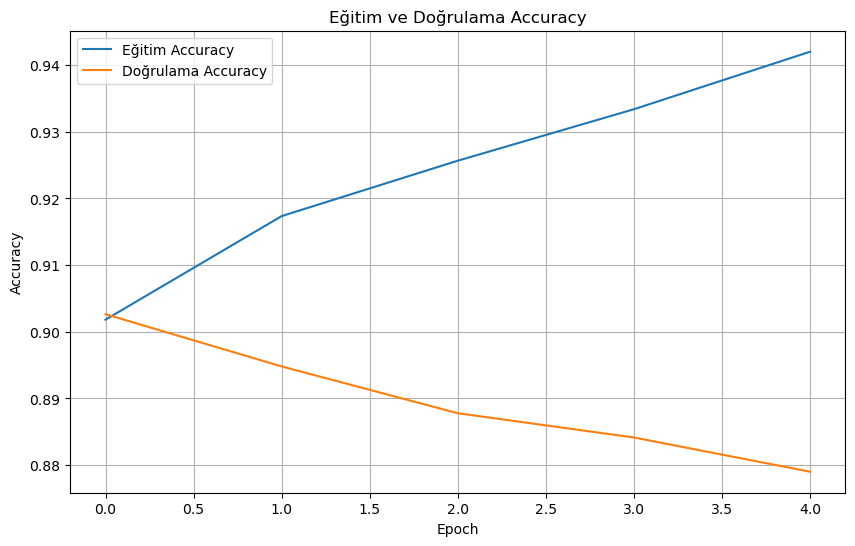

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['acc'], label='Eğitim Accuracy')
plt.plot(history.history['val_acc'], label='Doğrulama Accuracy')
plt.title('Eğitim ve Doğrulama Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

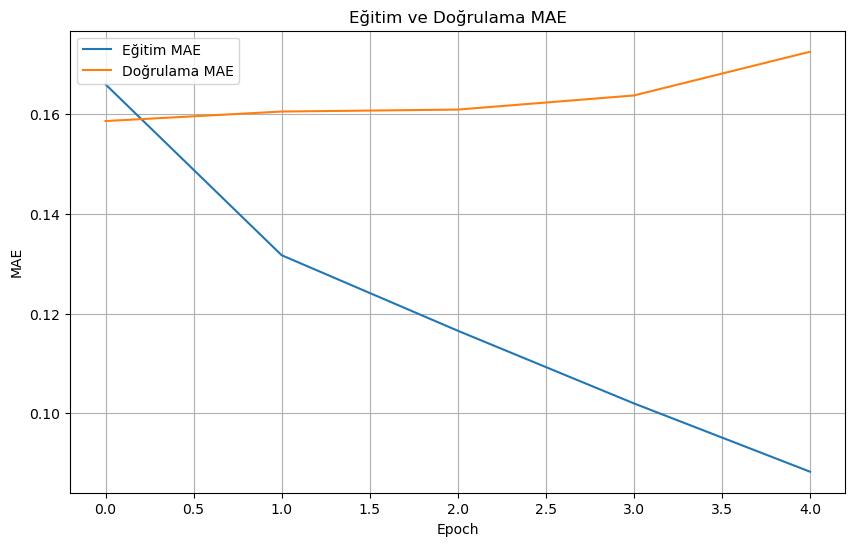

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_absolute_error'], label='Eğitim MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Doğrulama MAE')
plt.title('Eğitim ve Doğrulama MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [128]:
# Kullanıcıların ve oyunların listeleri
unique_users = np.unique(X[:, 0])  # Tüm kullanıcı ID'leri
unique_games = np.unique(X[:, 1])  # Tüm oyun ID'leri

# Rastgele 5 kullanıcı seç
random_users = np.random.choice(unique_users, size=5, replace=False)

# Kullanıcının daha önce oynadığı oyunları hariç tutarak öneri yap
recommendations = {}

for user in random_users:
    # Kullanıcının daha önce oynadığı oyunları al
    played_games = merged_dataset[merged_dataset['user_id'] == user]['app_id'].unique()
    candidate_games = np.setdiff1d(unique_games, played_games)  # Oynanmamış oyunları bul
    
    # Kullanıcının tüm oynanmamış oyunlar için tahminini hesapla
    user_array = np.array([user] * len(candidate_games))  # Kullanıcı ID'sini tekrarla
    game_array = candidate_games  # Oynanmamış oyunlar
    
    # Model tahminleri ve noise ekleme
    predictions = model.predict([user_array, game_array], verbose=0).flatten()
    predictions += np.random.normal(0, 0.01, size=len(predictions))  # Noise ekleyerek çeşitlendirme
    
    # En yüksek 3 tahmini bul
    top_3_indices = predictions.argsort()[-3:][::-1]  # En yüksek 3 skor
    top_3_games = candidate_games[top_3_indices]  # Oyun ID'leri
    
    # Kullanıcı ve önerilen oyunları sakla
    recommendations[user] = top_3_games

# Öneri sonuçlarını yazdır
print("Rastgele Kullanıcılara Önerilen Oyunlar:")
for user, games in recommendations.items():
    print(f"Kullanıcı {user}: Önerilen Oyunlar: {games}")

Rastgele Kullanıcılara Önerilen Oyunlar:
Kullanıcı 422680: Önerilen Oyunlar: [5548 5460 5629]
Kullanıcı 1473038: Önerilen Oyunlar: [5664 5404 2767]
Kullanıcı 1320301: Önerilen Oyunlar: [5056 3865 5041]
Kullanıcı 225720: Önerilen Oyunlar: [5588 4844 5532]
Kullanıcı 1048021: Önerilen Oyunlar: [4844 5985 4497]
